## 基于字符的心理问题聊天机器人：预训练后第二次训练

### 读入数据

In [1]:
import pandas as pd
df = pd.read_csv('/mnt/PsyQA.csv')
df.head()

,question,description,keywords,answer_text
0,高三后的迷茫，高考前的恐惧，能给我一些建议么？,现在的我，感觉就像是从自己出生以来就是多余的，我就不应该出现在这个世界，现在就读高三的我，面...,"成长,压力管理,工作学习,学生成长",抱抱~看到你的提问感觉你很焦虑，这个状态在高中高压下很容易出现。我想说的是，我看到了你的决心...
1,察觉到一种模式，我总喜欢自己检讨、批评自己？,我和我妈妈讲话会陷入一种很恶心的模式。我只要说遇到的烦恼她是无动于衷的，但是我一旦开始批评自...,"家庭,家庭创伤,成长过程,家人控制",楼主你好，看到你习惯性检讨自己，批评自己，我感到很心疼。看到你这种模式会出现在和妈妈的对话中...
2,高四，社恐，该不该分心去交点朋友，还是就保持高冷？,社恐挺严重，不喜欢离开舒适区，感觉和陌生同学交流需要很大勇气。我是应该认真学习独来独往，还是...,"人际,社交恐惧",楼主你好，看到你在犹豫要不要交朋友。高四的你应该是去到了完全陌生的班级，他们已经有自己的朋友...
3,心里其实是很抗拒的，怎么提高执行力？,想做的事情很多，一直在想却没有行动，怎么才能让自己行动起来呢？心里其实是很抗拒的，但是怎么才...,"成长,自我成长,人生意义",楼主你好，看到你有很多想做的事情，但是却没有行动起来。对自己没有行动这件事，内心也是很抗拒的...
4,新初中生，总是和妈妈闹矛盾，但又做不出行动怎么办？,长大了总喜欢跟家长顶嘴妈妈总说我顶嘴顶的很没道理但是憋着我也很不爽。妈妈很为我的学业担忧才初...,"成长,自我成长,自我接纳,学生成长",题主，你好，抱抱你呀～看了你的描述，你很不想影响到妈妈心情，但是在无意中挑起了争端，真的很能...


### 数据预处理

In [2]:
input_texts, target_texts = [], [] #输入、输出文本
input_vocabulary = set() #输入字典
output_vocabulary = set() #输出字典
start_token = '\t' #起始符
stop_token = '\n' #终止符
max_training_samples = min(25000, len(df)-1)

In [3]:
for input_text, target_text in zip(df.question, df.answer_text):
    target_text = start_token + target_text[:50] + stop_token #内存限制，只取前50个字作为回答
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_vocabulary:
            input_vocabulary.add(char) #输入字典加入新字
    for char in target_text:
        if char not in output_vocabulary:
            output_vocabulary.add(char) #输出字典加入新字

In [4]:
#排序
input_vocabulary = sorted(input_vocabulary)
output_vocabulary = sorted(output_vocabulary)
#长度/尺寸
input_vocab_size = len(input_vocabulary)
output_vocab_size = len(output_vocabulary)
#encoder和decoder输入的最大长度
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
#每个字到索引index的字典
input_token_index = dict([(char, i) for i, char in enumerate(input_vocabulary)])
target_token_index = dict([(char, i) for i, char in enumerate(output_vocabulary)])
#由index定位到字的字典
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [5]:
#构造字符级序列编码-解码训练集
import numpy as np
#0填充
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, input_vocab_size), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, output_vocab_size), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, output_vocab_size), dtype='float32')
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1
        if t>0:
            decoder_target_data[i, t-1, target_token_index[char]] = 1

### 建立基于lstm的seq2seq模型

In [6]:
import tensorflow
from tensorflow.compat.v1 import keras
batch_size = 100
epochs = 100
num_neurons = 256
encoder_inputs = keras.layers.Input(shape = (None, input_vocab_size)) 
encoder = keras.layers.LSTM(num_neurons, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c] #思想向量
decoder_inputs = keras.layers.Input(shape=(None, output_vocab_size))
decoder_lstm = keras.layers.LSTM(num_neurons, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) #状态初始化为encoder的思想向量，之后不断更新
decoder_dense = keras.layers.Dense(output_vocab_size, activation='softmax') 
decoder_outputs = decoder_dense(decoder_outputs)
model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=tensorflow.optimizers.RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2825)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 3417)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 3155968     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  3762176     input_2[0][0]                    
                                                                 lstm[0][1]                   

### 模型继续训练

In [7]:
model.load_weights("PsyQA_lstm_50_weights_1.h5") #上一次训练的权重

In [8]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=200, validation_split=0.1, workers=16)

Train on 20106 samples, validate on 2235 samples
Epoch 1/200
20106/20106 [==============================] - 61s 3ms/sample - loss: 1.3860 - acc: 0.6680 - val_loss: 4.4899 - val_acc: 0.3480
Epoch 2/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.3730 - acc: 0.6715 - val_loss: 4.5072 - val_acc: 0.3433
Epoch 3/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.3697 - acc: 0.6726 - val_loss: 4.5163 - val_acc: 0.3463
Epoch 4/200
20106/20106 [==============================] - 57s 3ms/sample - loss: 1.3687 - acc: 0.6726 - val_loss: 4.4864 - val_acc: 0.3443
Epoch 5/200
20106/20106 [==============================] - 57s 3ms/sample - loss: 1.3669 - acc: 0.6728 - val_loss: 4.5077 - val_acc: 0.3484
Epoch 6/200
20106/20106 [==============================] - 58s 3ms/sample - loss: 1.3648 - acc: 0.6733 - val_loss: 4.4928 - val_acc: 0.3481
Epoch 7/200
20106/20106 [==============================] - 57s 3ms/sample - loss: 1.3633 - acc: 0.6735 - val_lo

Epoch 59/200
20106/20106 [==============================] - 57s 3ms/sample - loss: 1.2876 - acc: 0.6892 - val_loss: 4.7133 - val_acc: 0.3432
Epoch 60/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.2859 - acc: 0.6898 - val_loss: 4.7174 - val_acc: 0.3403
Epoch 61/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.2842 - acc: 0.6903 - val_loss: 4.7249 - val_acc: 0.3359
Epoch 62/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.2831 - acc: 0.6903 - val_loss: 4.6991 - val_acc: 0.3402
Epoch 63/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.2818 - acc: 0.6908 - val_loss: 4.7317 - val_acc: 0.3384
Epoch 64/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.2804 - acc: 0.6912 - val_loss: 4.6956 - val_acc: 0.3412
Epoch 65/200
20106/20106 [==============================] - 56s 3ms/sample - loss: 1.2792 - acc: 0.6911 - val_loss: 4.7708 - val_acc: 0.3363
Epoch 66/200


Epoch 117/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.2188 - acc: 0.7042 - val_loss: 4.9052 - val_acc: 0.3360
Epoch 118/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.2176 - acc: 0.7041 - val_loss: 4.9067 - val_acc: 0.3351
Epoch 119/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.2167 - acc: 0.7046 - val_loss: 4.8644 - val_acc: 0.3398
Epoch 120/200
20106/20106 [==============================] - 58s 3ms/sample - loss: 1.2146 - acc: 0.7051 - val_loss: 4.8782 - val_acc: 0.3380
Epoch 121/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.2133 - acc: 0.7050 - val_loss: 4.8667 - val_acc: 0.3403
Epoch 122/200
20106/20106 [==============================] - 58s 3ms/sample - loss: 1.2128 - acc: 0.7054 - val_loss: 4.8758 - val_acc: 0.3364
Epoch 123/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.2118 - acc: 0.7056 - val_loss: 4.8834 - val_acc: 0.3394
Epoch 

Epoch 175/200
20106/20106 [==============================] - 58s 3ms/sample - loss: 1.1618 - acc: 0.7162 - val_loss: 5.0215 - val_acc: 0.3345
Epoch 176/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.1609 - acc: 0.7158 - val_loss: 5.0169 - val_acc: 0.3343
Epoch 177/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.1595 - acc: 0.7165 - val_loss: 5.0125 - val_acc: 0.3361
Epoch 178/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.1589 - acc: 0.7166 - val_loss: 5.0570 - val_acc: 0.3301
Epoch 179/200
20106/20106 [==============================] - 60s 3ms/sample - loss: 1.1587 - acc: 0.7166 - val_loss: 5.0459 - val_acc: 0.3316
Epoch 180/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.1567 - acc: 0.7168 - val_loss: 5.0441 - val_acc: 0.3361
Epoch 181/200
20106/20106 [==============================] - 59s 3ms/sample - loss: 1.1569 - acc: 0.7171 - val_loss: 5.0354 - val_acc: 0.3348
Epoch 

### 权重保存

In [9]:
model.save_weights("PsyQA_lstm_50_weights_2.h5")

### acc与loss曲线

Text(0.5, 1.0, 'acc - epochs')

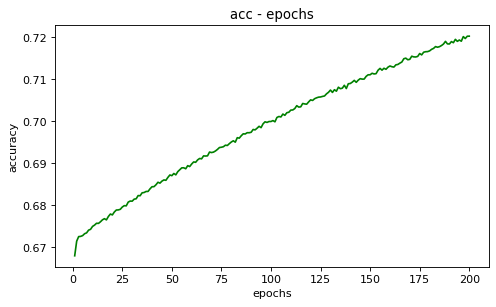

In [10]:
from matplotlib import pyplot as plt
acc = history.history['acc']
plt.figure(figsize=(7,4),dpi=80) #图片大小、像素
x = range(1,201) #横坐标
plt.plot(x, acc, label = 'acc', color='green')
plt.xlabel('epochs') #x轴标题
plt.ylabel('accuracy') #y轴标题
plt.title("acc - epochs") #标题

Text(0.5, 1.0, 'loss - epochs')

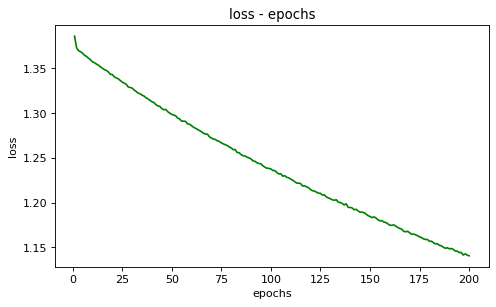

In [11]:
loss = history.history['loss']
plt.figure(figsize=(7,4),dpi=80) #图片大小、像素
x = range(1,201) #横坐标
plt.plot(x, loss, label = 'loss', color='green')
plt.xlabel('epochs') #x轴标题
plt.ylabel('loss') #y轴标题
plt.title("loss - epochs") #标题

### 根据以上网络结构编写回复生成器

In [12]:
#构造回复生成器模型
encoder_model = keras.models.Model(encoder_inputs, encoder_states)
thought_input = [keras.layers.Input(shape=(num_neurons, )), keras.layers.Input(shape=(num_neurons, ))]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=thought_input)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.models.Model([decoder_inputs] + thought_input, [decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 3417)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  3762176     input_2[0][0]                    
                                                                 input_3[0][0]              

In [13]:
#建立基于字符的翻译器
def decode_sequence(input_seq):
    thought = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, output_vocab_size))
    target_seq[0, 0, target_token_index[stop_token]] = 1
    stop_condition = False
    generated_sequence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + thought)
        generated_token_idx = np.argmax(output_tokens[0, -1, :])
        generated_char = reverse_target_char_index[generated_token_idx]
        generated_sequence += generated_char
        if (generated_char == stop_token):  #生成停止符就停止
            stop_condition = True
        target_seq = np.zeros((1, 1, output_vocab_size))
        target_seq[0, 0, generated_token_idx] = 1
        thought = [h,c]
    return generated_sequence
#生成回复
def response(input_text):
    input_seq = np.zeros((1, max_encoder_seq_length, input_vocab_size), dtype='float32')
    for t, char in enumerate(input_text):
        input_seq[0, t, input_token_index[char]] = 1
    decoded_sentence = decode_sequence(input_seq)
    print('Bot Reply (Decoded sentence):', decoded_sentence)

### 聊天测试

In [21]:
response('总是要考虑很多问题，我感觉我活在世界上就没有意义？')

Bot Reply (Decoded sentence): 你好！看到你的问题，我想说了，我也是一个忙在生活的人，自己也不错，以计算个算依赖依赖强，但重重的选量。



In [15]:
response('我要通过这种方式和父亲断绝关系！')

Bot Reply (Decoded sentence): 你好如果一下你父母不理解和她的关心，视和理解。我也很担心这样做梦吧，是陌生的。你不喜欢你说你多重的人



In [17]:
response('她性格实在是太慢了，要不要继续维持这段友谊？')

Bot Reply (Decoded sentence): 题主，你好，抱抱你呀～看了你的描述，你最近的状态不太好，因为自己特别的内心有怀疑自己，或许是你的自身

